In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import datetime
from tensorflow.keras.callbacks import TensorBoard


# ── (your existing parameters & functions unchanged) ─────────────────────────
tess_dir    = "./TESSdataset"
ravdess_dir = "./ravdess_by_emotion"
sr = 16000; n_mfcc = 13; max_length = 85
emotion_map = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'pleasant_surprised': 5,
    'sad': 6
}

def extract_mfcc(file_path, max_length=85):
    y, _ = librosa.load(file_path, sr=sr)
    hop = int(len(y) / (max_length - 1))
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop)
    if mfcc.shape[1] < max_length:
        mfcc = np.pad(mfcc, ((0,0),(0,max_length-mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_length]
    return mfcc

def load_all_data(base_dir):
    X, y = [], []
    for emo in os.listdir(base_dir):
        p = os.path.join(base_dir, emo)
        if not os.path.isdir(p): continue
        lbl = emotion_map.get(emo.lower())
        if lbl is None: continue
        for f in os.listdir(p):
            if not f.lower().endswith('.wav'): continue
            mf = extract_mfcc(os.path.join(p,f), max_length)
            X.append(np.expand_dims(mf, -1))
            y.append(lbl)
    return np.array(X), np.array(y)

# ── LOAD + SPLIT ────────────────────────────────────────────────────────────
X_tess, y_tess = load_all_data(tess_dir)
X_rav,  y_rav = load_all_data(ravdess_dir)
X_all = np.concatenate([X_tess, X_rav], axis=0)
y_all = np.concatenate([y_tess, y_rav], axis=0)

X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all, test_size=0.15, random_state=42, stratify=y_all)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

print("Train shape:", X_train.shape)
print("Val   shape:", X_val.shape)
print("Test  shape:", X_test.shape)

# ── NOISE AUGMENTATION ───────────────────────────────────────────────────────
noise_std = 0.01
X_train_noisy = X_train + noise_std * np.random.randn(*X_train.shape)

X_train_aug = np.concatenate([X_train, X_train_noisy], axis=0)
y_train_aug = np.concatenate([y_train, y_train], axis=0)

perm = np.random.permutation(len(X_train_aug))
X_train_aug, y_train_aug = X_train_aug[perm], y_train_aug[perm]

# ── MODEL DEFINITION ─────────────────────────────────────────────────────────
class EmotionClassifier(tf.keras.Model):
    def __init__(self, num_classes):
        super().__init__()
        wd = 1e-4
        self.conv1 = layers.Conv2D(32,3,padding='same',kernel_regularizer=regularizers.l2(wd))
        self.bn1, self.act1 = layers.BatchNormalization(), layers.Activation('relu')
        self.pool1, self.drop1 = layers.MaxPooling2D(2), layers.Dropout(0.3)
        self.conv2 = layers.Conv2D(64,3,padding='same',kernel_regularizer=regularizers.l2(wd))
        self.bn2, self.act2 = layers.BatchNormalization(), layers.Activation('relu')
        self.pool2, self.drop2 = layers.MaxPooling2D(2), layers.Dropout(0.3)
        self.conv3 = layers.Conv2D(128,3,padding='same',kernel_regularizer=regularizers.l2(wd))
        self.bn3, self.act3 = layers.BatchNormalization(), layers.Activation('relu')
        self.pool3, self.drop3 = layers.MaxPooling2D(2), layers.Dropout(0.3)
        self.flatten = layers.Flatten()
        self.d1      = layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(wd))
        self.drop4   = layers.Dropout(0.4)
        self.d2      = layers.Dense(num_classes,activation='softmax')

    def call(self, x, training=False):
        x = self.pool1(self.act1(self.bn1(self.conv1(x),training=training)))
        x = self.drop1(x, training=training)
        x = self.pool2(self.act2(self.bn2(self.conv2(x),training=training)))
        x = self.drop2(x, training=training)
        x = self.pool3(self.act3(self.bn3(self.conv3(x),training=training)))
        x = self.drop3(x, training=training)
        x = self.flatten(x)
        x = self.drop4(self.d1(x), training=training)
        return self.d2(x)

num_classes = len(emotion_map)
model = EmotionClassifier(num_classes)
model.build(input_shape=(None, n_mfcc, max_length, 1))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ── COMPILE ─────────────────────────────────────────────────────────────────
num_classes = len(emotion_map)
model = EmotionClassifier(num_classes)
model.build(input_shape=(None, n_mfcc, max_length, 1))
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ── LOGGING SETUP ────────────────────────────────────────────────────────────
# CSV logger
logfile = "CNNCombine2.log"
csv_logger = CSVLogger(logfile, append=False)

# TensorBoard logger
# create a new sub‐folder in "logs/fit" with current timestamp
log_dir = os.path.join(
    "logs", "fit",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,       # record activation histograms every epoch
    write_graph=True,       # log the graph (optional)
    write_images=False      # you can also log model weights as images
)

# ── TRAINING ─────────────────────────────────────────────────────────────────
import time
start_time = time.time()
history = model.fit(
    X_train_aug, y_train_aug,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[csv_logger, tensorboard_cb]
)
train_time = time.time() - start_time
print(f"Combined CNN training time: {train_time:.2f} seconds")
print(f"Training history saved to {logfile}")
print(f"TensorBoard logs saved to {log_dir}")


Train shape: (2832, 13, 85, 1)
Val   shape: (608, 13, 85, 1)
Test  shape: (608, 13, 85, 1)
Epoch 1/50
177/177 [==============================] - 10s 10ms/step - loss: 1.9288 - accuracy: 0.2394 - val_loss: 1.5189 - val_accuracy: 0.4391
Epoch 2/50
177/177 [==============================] - 2s 10ms/step - loss: 1.3103 - accuracy: 0.4786 - val_loss: 1.1259 - val_accuracy: 0.5609
Epoch 3/50
177/177 [==============================] - 2s 9ms/step - loss: 1.0378 - accuracy: 0.5915 - val_loss: 0.9025 - val_accuracy: 0.6266
Epoch 4/50
177/177 [==============================] - 1s 7ms/step - loss: 0.8934 - accuracy: 0.6534 - val_loss: 0.7360 - val_accuracy: 0.7039
Epoch 5/50
177/177 [==============================] - 1s 7ms/step - loss: 0.7805 - accuracy: 0.7127 - val_loss: 0.5378 - val_accuracy: 0.7796
Epoch 6/50
177/177 [==============================] - 1s 8ms/step - loss: 0.7212 - accuracy: 0.7263 - val_loss: 0.6052 - val_accuracy: 0.7549
Epoch 7/50
177/177 [==============================] - 

19/19 [==============================] - 0s 7ms/step
Test‐set accuracy: 0.908


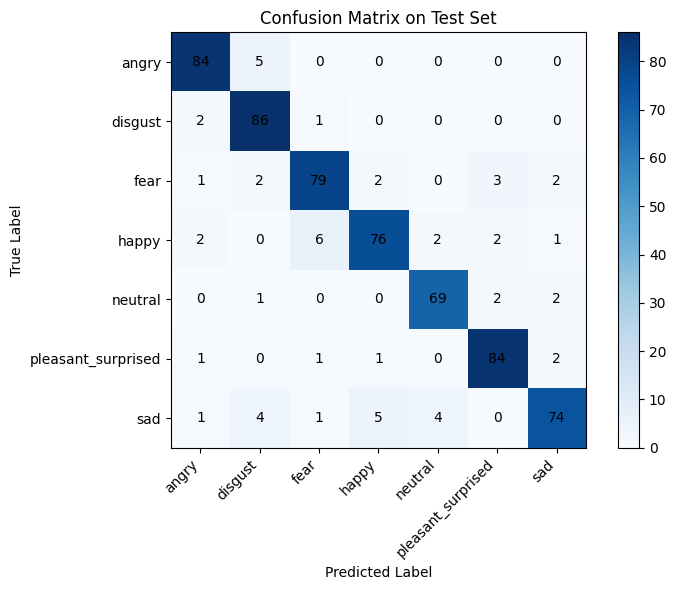

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# ── 0) (If you haven't already) get y_pred from your model:
y_pred = np.argmax(model.predict(X_test), axis=1)

# ── 1) Compute and print total test‐set accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"Test‐set accuracy: {test_acc:.3f}")

# ── 2) Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprised', 'sad']

# ── 3) Plot using pure matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, aspect='equal', cmap='Blues')
fig.colorbar(im, ax=ax)

# Annotate each cell with its count
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm[i, j], ha='center', va='center')

# Set axis labels and ticks
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()
